In [1]:
import os
import time
import math
import glob
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as T
from torchvision import models

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

device = torch.device("cuda")

In [2]:
! unzip -q /kaggle/input/tgs-salt-identification-challenge/competition_data.zip

In [3]:
image_path = "/kaggle/working/competition_data/train/images"
mask_path = "/kaggle/working/competition_data/train/masks"

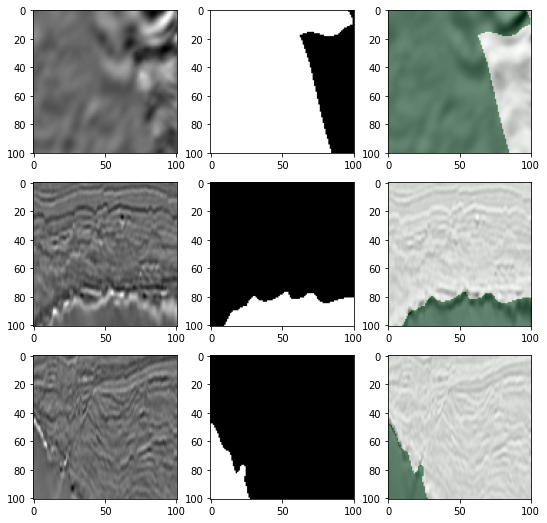

In [4]:
names = ['0a19821a16','0df53ae04c','1544a0e952']
images = [Image.open(os.path.join(image_path, name+'.png')) for name in names]
masks = [Image.open(os.path.join(mask_path, name+'.png')) for name in names]

transforms = T.Compose([T.Grayscale(), T.ToTensor()])
x = torch.stack([transforms(image) for image in images])
y = torch.stack([transforms(mask) for mask in masks])

fig = plt.figure( figsize=(9, 9))

ax = fig.add_subplot(331)
plt.imshow(images[0])
ax = fig.add_subplot(332)
plt.imshow(masks[0])
ax = fig.add_subplot(333)
ax.imshow(x[0].squeeze(), cmap="Greys")
ax.imshow(y[0].squeeze(), alpha=0.5, cmap="Greens")

ax = fig.add_subplot(334)
plt.imshow(images[1])
ax = fig.add_subplot(335)
plt.imshow(masks[1])
ax = fig.add_subplot(336)
ax.imshow(x[1].squeeze(), cmap="Greys")
ax.imshow(y[1].squeeze(), alpha=0.5, cmap="Greens")

ax = fig.add_subplot(337)
plt.imshow(images[2])
ax = fig.add_subplot(338)
plt.imshow(masks[2])
ax = fig.add_subplot(339)
ax.imshow(x[2].squeeze(), cmap="Greys")
ax.imshow(y[2].squeeze(), alpha=0.5, cmap="Greens")

plt.show()

In [5]:
class segmentDataset(Dataset):
    def __init__(self, image_path, mask_path):
        self.image_path = image_path
        self.mask_path = mask_path
        
        image_list= glob.glob(image_path +'/*.png')
        sample_names = []
        for file in image_list:
            sample_names.append(file.split('/')[-1].split('.')[0])
            
        self.sample_names = sample_names
        
        self.transforms = T.Compose([T.Grayscale(), T.ToTensor()])
            
    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.image_path, self.sample_names[idx]+'.png') )
        mask = Image.open(os.path.join(self.mask_path, self.sample_names[idx]+'.png') )
        return self.transforms(image), self.transforms(mask)

    def __len__(self):
        return len(self.sample_names)

In [6]:
train_dataset = segmentDataset(image_path, mask_path)

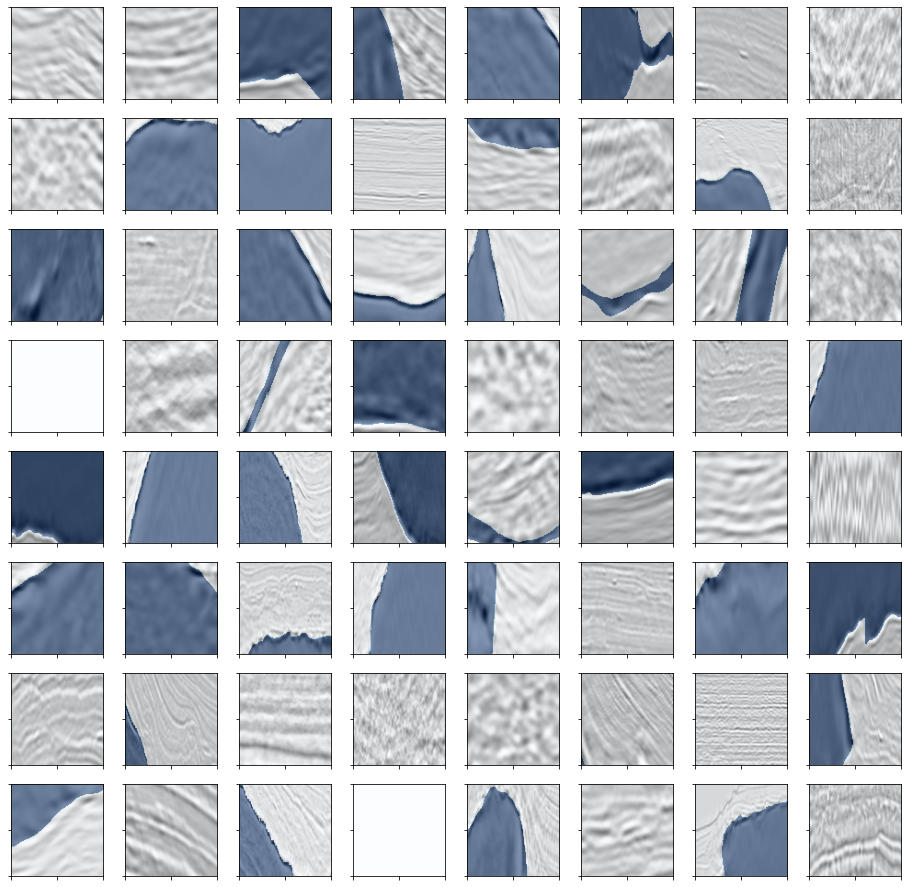

In [7]:
max_images = 64
grid_width = 8
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width*2, grid_height*2))
for i, idx in enumerate(range(max_images)):
    image, mask = train_dataset[idx]
    
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(image.squeeze(), cmap="Greys")
    ax.imshow(mask.squeeze(), alpha=0.5, cmap="Blues")
   
    ax.set_yticklabels([])
    ax.set_xticklabels([])
plt.show()

In [8]:
class convBlock(nn.Module):
    def __init__(self, in_channels, filters, size, stride = 1, activation = True):
        super(convBlock, self).__init__()
        self.activation = activation
        self.conv = nn.Conv2d(in_channels, filters, size, stride = stride, padding = size//2)
        self.norm = nn.BatchNorm2d(filters)

    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        if self.activation:
            return F.relu(x)
        else:
            return x
    
class residualBlock(nn.Module):
    def __init__(self, in_channels, filters, size = 3):
        super(residualBlock, self).__init__()

        self.norm = nn.BatchNorm2d(in_channels)
        self.conv1 = convBlock(in_channels, filters, size)
        self.conv2 = convBlock(filters, filters, size, activation=False)

    def forward(self, x):
        residual = x  
        x = F.relu(x)
        x = self.norm(x)
        x = self.conv1(x)
        x = self.conv2(x)
        #x += residual
        return x 
    
class deconvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size = 2, stride = 2):
        super(deconvBlock, self).__init__()
        
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size = kernel_size, stride = stride)

    def forward(self, x1, x2):
        xd = self.deconv(x1)
        x = torch.cat([xd, x2], dim = 1)
        return x

In [9]:
class UnetModel(nn.Module):

    def __init__(self, filters = 16, dropout = 0.5):
        super(UnetModel, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, filters, 3, padding = 1),
            residualBlock(filters, filters),
            residualBlock(filters, filters),
            nn.ReLU()
        )
        
        self.conv2 = nn.Sequential(
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout/2),
            nn.Conv2d(filters, filters * 2, 3, padding = 1),
            residualBlock(filters * 2, filters * 2),
            residualBlock(filters * 2, filters * 2),
            nn.ReLU()
        )
        
        self.conv3 = nn.Sequential(
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout),
            nn.Conv2d(filters * 2, filters * 4, 3, padding = 1),
            residualBlock(filters * 4, filters * 4),
            residualBlock(filters * 4, filters * 4),
            nn.ReLU()
        )
        
        self.conv4 = nn.Sequential(
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout),
            nn.Conv2d(filters * 4, filters * 8, 3, padding = 1),
            residualBlock(filters * 8, filters * 8),
            residualBlock(filters * 8, filters * 8),
            nn.ReLU()
        )
            

        self.middle = nn.Sequential(
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout),
            nn.Conv2d(filters * 8, filters * 16, 3, padding = 3//2),
            residualBlock(filters * 16, filters * 16),
            residualBlock(filters * 16, filters * 16),
            nn.ReLU()
        )
        
        self.deconv4 = deconvBlock(filters * 16, filters * 8, 2)
        self.upconv4 = nn.Sequential(
            nn.Dropout(dropout),
            nn.Conv2d(filters * 16, filters * 8, 3, padding = 1),
            residualBlock(filters * 8, filters * 8),
            residualBlock(filters * 8, filters * 8),
            nn.ReLU()
        )
  

        self.deconv3 = deconvBlock(filters * 8, filters * 4, 3)
        self.upconv3 = nn.Sequential(
            nn.Dropout(dropout),
            nn.Conv2d(filters * 8, filters * 4, 3, padding = 1),
            residualBlock(filters * 4, filters * 4),
            residualBlock(filters * 4, filters * 4),
            nn.ReLU()
        )
        
        self.deconv2 = deconvBlock(filters * 4, filters * 2, 2)
        self.upconv2 = nn.Sequential(
            nn.Dropout(dropout),
            nn.Conv2d(filters * 4, filters * 2, 3, padding = 1),
            residualBlock(filters * 2, filters * 2),
            residualBlock(filters * 2, filters * 2),
            nn.ReLU()
        )

        self.deconv1 = deconvBlock(filters * 2, filters, 3)
        self.upconv1 = nn.Sequential(
            nn.Dropout(dropout),
            nn.Conv2d(filters * 2, filters, 3, padding = 1),
            residualBlock(filters, filters),
            residualBlock(filters, filters),
            nn.ReLU(),
            nn.Dropout(dropout/2),
            nn.Conv2d(filters, 1, 3, padding = 1)
        )

    def forward(self, x):
        conv1 = self.conv1(x) 
        # 101 -> 50
        conv2 = self.conv2(conv1) 
        # 50 -> 25
        conv3 = self.conv3(conv2) 
        # 25 -> 12
        conv4 = self.conv4(conv3) 
        # 12 - 6
        x = self.middle(conv4) 
        
        # 6 -> 12
        x = self.deconv4(x, conv4)
        x = self.upconv4(x)
        # 12 -> 25
        x = self.deconv3(x, conv3)
        x = self.upconv3(x)
        # 25 -> 50
        x = self.deconv2(x, conv2)
        x = self.upconv2(x)
        # 50 -> 101
        x = self.deconv1(x, conv1)
        x = self.upconv1(x)

        return x

In [10]:
def get_iou_score(outputs, labels):
    A = labels.squeeze().bool()
    pred = torch.where(outputs<0., torch.zeros_like(outputs), torch.ones_like(outputs))
    B = pred.squeeze().bool()
    intersection = (A & B).float().sum((0,1))
    union = (A| B).float().sum((0,1)) 
    iou = (intersection + 1e-6) / (union + 1e-6)  
    return iou
  
def train_one_batch(model, x, y):
    x, y = x.to(device), y.to(device)

    outputs = model(x)
    loss = loss_fn(outputs, y)
    iou = get_iou_score(outputs, y).mean()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item(), iou.item()

In [11]:
NUM_EPOCHS = 70
BATCH_SIZE = 64

model = UnetModel().to(device)
model.train()
optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max')

loss_fn = nn.BCEWithLogitsLoss()

train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = True)
steps  = train_dataset.__len__()// BATCH_SIZE
print(steps,"steps per epoch")

start = time.time()
train_losses = []
train_ious = []
for epoch in range(1, NUM_EPOCHS + 1):
    print('-' * 10)
    print('Epoch {}/{}'.format(epoch, NUM_EPOCHS))
    running_iou = []
    running_loss = []
    for step, (x, y) in enumerate(train_dataloader):
        loss, iou = train_one_batch(model, x, y)
        running_iou.append(iou)
        running_loss.append(loss)
        print('\r{:6.1f} %\tloss {:8.4f}\tIoU {:8.4f}'.format(100*(step+1)/steps, loss,iou), end = "") 
        
    print('\r{:6.1f} %\tloss {:8.4f}\tIoU {:8.4f}\t{}'.format(100*(step+1)/steps,np.mean(running_loss),np.mean(running_iou), timeSince(start)))
    scheduler.step(np.mean(running_iou))
    
    train_losses.append(loss)
    train_ious.append(iou)

62 steps per epoch
----------
Epoch 1/70
 100.0 %	loss   0.4936	IoU   0.4530	0m 22s
----------
Epoch 2/70
 100.0 %	loss   0.3472	IoU   0.5403	0m 38s
----------
Epoch 3/70
 100.0 %	loss   0.2941	IoU   0.6036	0m 55s
----------
Epoch 4/70
 100.0 %	loss   0.2879	IoU   0.5923	1m 11s
----------
Epoch 5/70
 100.0 %	loss   0.2588	IoU   0.6289	1m 28s
----------
Epoch 6/70
 100.0 %	loss   0.2353	IoU   0.6718	1m 44s
----------
Epoch 7/70
 100.0 %	loss   0.2301	IoU   0.6511	2m 1s
----------
Epoch 8/70
 100.0 %	loss   0.2256	IoU   0.6746	2m 17s
----------
Epoch 9/70
 100.0 %	loss   0.2199	IoU   0.6832	2m 33s
----------
Epoch 10/70
 100.0 %	loss   0.2233	IoU   0.6888	2m 50s
----------
Epoch 11/70
 100.0 %	loss   0.2075	IoU   0.7093	3m 6s
----------
Epoch 12/70
 100.0 %	loss   0.2083	IoU   0.7099	3m 23s
----------
Epoch 13/70
 100.0 %	loss   0.2245	IoU   0.6943	3m 39s
----------
Epoch 14/70
 100.0 %	loss   0.2077	IoU   0.7110	3m 55s
----------
Epoch 15/70
 100.0 %	loss   0.2087	IoU   0.7110	4m 12s
--

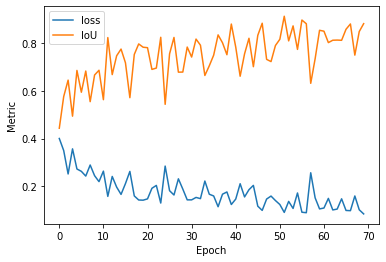

In [12]:
plt.plot(train_losses, label = 'loss')
plt.plot(train_ious, label = 'IoU')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.show()

In [13]:
os.mkdir('./new_train')
os.mkdir('./new_mask')

In [14]:
model_path = 'unet_cpu.pth'
gpumodel_path = 'unet_gpu.pth'
## save weights    
torch.save(model.cpu().state_dict(), model_path)
torch.save(model.state_dict(), gpumodel_path)

In [15]:
imglist=os.listdir(image_path)
masklist=os.listdir(mask_path)
i=0
import shutil
for ele in imglist:
    i+=1
    img=Image.open(image_path+'/'+ele)
    mask=Image.open(mask_path+'/'+ele)
    tensor = T.Compose([T.Grayscale(), T.ToTensor()])
    img=tensor(img).unsqueeze(0)
    mask=tensor(mask).unsqueeze(0)
    output=model(img)
    print(get_iou_score(output,mask))
    if(get_iou_score(output,mask)>0.6) and tensor(Image.open(mask_path+'/'+ele)).sum(1).sum(1)!=0 :
        shutil.copy(image_path+'/'+ele,"/kaggle/working/new_train/"+ele)
        shutil.copy(mask_path+'/'+ele,"/kaggle/working/new_mask/"+ele)

tensor(4.1135e-10)
tensor(3.5051e-10)
tensor(0.3553)
tensor(0.8628)
tensor(0.3268)
tensor(0.3687)
tensor(3.5663e-10)
tensor(3.3636e-10)
tensor(3.6928e-10)
tensor(0.3444)
tensor(0.3157)
tensor(3.3278e-10)
tensor(0.5152)
tensor(3.7566e-10)
tensor(0.9537)
tensor(3.2227e-10)
tensor(0.2832)
tensor(3.7286e-10)
tensor(0.4060)
tensor(0.7789)
tensor(0.9228)
tensor(0.1689)
tensor(0.5373)
tensor(3.2216e-10)
tensor(3.5753e-10)
tensor(3.6284e-10)
tensor(0.2591)
tensor(0.2873)
tensor(3.3367e-10)
tensor(3.5386e-10)
tensor(3.9872e-10)
tensor(0.2741)
tensor(0.2750)
tensor(0.3210)
tensor(0.6453)
tensor(0.4217)
tensor(0.2802)
tensor(0.7441)
tensor(3.2884e-10)
tensor(3.9231e-10)
tensor(0.2789)
tensor(0.3211)
tensor(0.5253)
tensor(0.3860)
tensor(0.8816)
tensor(3.3795e-10)
tensor(0.3257)
tensor(0.3639)
tensor(3.2258e-10)
tensor(0.2728)
tensor(3.6075e-10)
tensor(3.8610e-10)
tensor(3.0665e-10)
tensor(0.0077)
tensor(4.3783e-10)
tensor(0.9389)
tensor(0.7945)
tensor(3.6982e-10)
tensor(0.5222)
tensor(2.8703e-10)


In [16]:
print(len(os.listdir("/kaggle/working/new_train/")))
print(len(os.listdir("/kaggle/working/new_mask/")))

654
654


# 自蒸馏法再次训练

In [17]:
new_dataset = segmentDataset("/kaggle/working/new_train/", "/kaggle/working/new_mask/")

In [18]:
NUM_EPOCHS = 70
BATCH_SIZE = 64

# model = torch.load('./unet_gpu.pth')
# model.train()
optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max')
model=model.to(device)
loss_fn = nn.BCEWithLogitsLoss()

train_dataloader = DataLoader(new_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = True)
steps  = train_dataset.__len__()// BATCH_SIZE
print(steps,"steps per epoch")

start = time.time()
train_losses = []
train_ious = []
for epoch in range(1, NUM_EPOCHS + 1):
    print('-' * 10)
    print('Epoch {}/{}'.format(epoch, NUM_EPOCHS))
    running_iou = []
    running_loss = []
    for step, (x, y) in enumerate(train_dataloader):
        loss, iou = train_one_batch(model, x, y)
        running_iou.append(iou)
        running_loss.append(loss)
        print('\r{:6.1f} %\tloss {:8.4f}\tIoU {:8.4f}'.format(100*(step+1)/steps, loss,iou), end = "") 
        
    print('\r{:6.1f} %\tloss {:8.4f}\tIoU {:8.4f}\t{}'.format(100*(step+1)/steps,np.mean(running_loss),np.mean(running_iou), timeSince(start)))
    scheduler.step(np.mean(running_iou))
    
    train_losses.append(loss)
    train_ious.append(iou)

62 steps per epoch
----------
Epoch 1/70
  16.1 %	loss   0.0995	IoU   0.8929	0m 2s
----------
Epoch 2/70
  16.1 %	loss   0.0790	IoU   0.9152	0m 5s
----------
Epoch 3/70
  16.1 %	loss   0.0704	IoU   0.9238	0m 8s
----------
Epoch 4/70
  16.1 %	loss   0.0654	IoU   0.9282	0m 11s
----------
Epoch 5/70
  16.1 %	loss   0.0618	IoU   0.9318	0m 13s
----------
Epoch 6/70
  16.1 %	loss   0.0606	IoU   0.9313	0m 16s
----------
Epoch 7/70
  16.1 %	loss   0.0595	IoU   0.9331	0m 19s
----------
Epoch 8/70
  16.1 %	loss   0.0549	IoU   0.9378	0m 21s
----------
Epoch 9/70
  16.1 %	loss   0.0563	IoU   0.9362	0m 24s
----------
Epoch 10/70
  16.1 %	loss   0.0544	IoU   0.9389	0m 27s
----------
Epoch 11/70
  16.1 %	loss   0.0544	IoU   0.9383	0m 29s
----------
Epoch 12/70
  16.1 %	loss   0.0544	IoU   0.9384	0m 32s
----------
Epoch 13/70
  16.1 %	loss   0.0543	IoU   0.9382	0m 35s
----------
Epoch 14/70
  16.1 %	loss   0.0576	IoU   0.9368	0m 38s
----------
Epoch 15/70
  16.1 %	loss   0.0574	IoU   0.9358	0m 40s
---

In [19]:
def demo_get_iou_score(outputs, labels):
    A = labels.squeeze().bool()
    pred = torch.where(outputs<0., torch.zeros_like(outputs), torch.ones_like(outputs))
    B = pred.squeeze().bool()
    intersection = (A & B).float().sum((1,2))
    union = (A| B).float().sum((1,2)) 
    iou = (intersection + 1e-6) / (union + 1e-6)  
    return iou
  
def demo_train_one_batch(model, x, y):
    x, y = x.to(device), y.to(device)

    outputs = model(x)
    loss = loss_fn(outputs, y)
    iou = demo_get_iou_score(outputs, y).mean()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item(), iou.item()

torch.Size([3, 1, 101, 101])


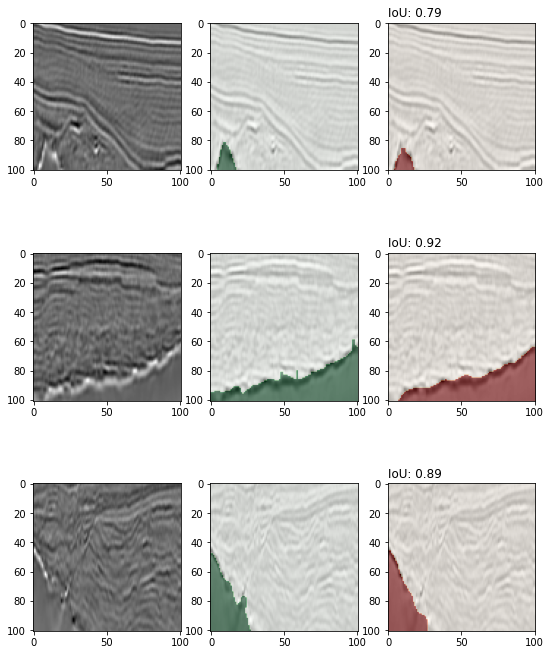

In [20]:
model.eval()
names = ['6caec01e67','2bfa664017','1544a0e952']
images = [Image.open(os.path.join(image_path, name+'.png')) for name in names]
masks = [Image.open(os.path.join(mask_path, name+'.png')) for name in names]

transforms = T.Compose([T.Grayscale(), T.ToTensor()])
x = torch.stack([transforms(image) for image in images]).cuda()
y = torch.stack([transforms(mask) for mask in masks]).cuda()
outputs = model(x)
preds = torch.where(outputs<0., torch.zeros_like(outputs), torch.ones_like(outputs)).cuda()
ious = demo_get_iou_score(outputs, y).cuda()
print(outputs.shape)
fig = plt.figure( figsize=(9, 12))

ax = fig.add_subplot(331)
plt.imshow(images[0])
ax = fig.add_subplot(332)
x=x.cpu().numpy()
y=y.cpu().numpy()
preds=preds.cpu().numpy()
ious=ious.cpu().numpy()
ax.imshow(x[0].squeeze(), cmap="Greys")
ax.imshow(y[0].squeeze(), alpha=0.5, cmap="Greens")
ax = fig.add_subplot(333)
ax.imshow(x[0].squeeze(), cmap="Greys")
ax.imshow(preds[0].squeeze(), alpha=0.5, cmap="OrRd")
ax.set_title("IoU: " + str(round(ious[0].item(), 2)), loc = 'left')

ax = fig.add_subplot(334)
plt.imshow(images[1])
ax = fig.add_subplot(335)
ax.imshow(x[1].squeeze(), cmap="Greys")
ax.imshow(y[1].squeeze(), alpha=0.5, cmap="Greens")
ax = fig.add_subplot(336)
ax.imshow(x[1].squeeze(), cmap="Greys")
ax.imshow(preds[1].squeeze(), alpha=0.5, cmap="OrRd")
ax.set_title("IoU: " + str(round(ious[1].item(), 2)), loc = 'left')

ax = fig.add_subplot(337)
plt.imshow(images[2])
ax = fig.add_subplot(338)
ax.imshow(x[2].squeeze(), cmap="Greys")
ax.imshow(y[2].squeeze(), alpha=0.5, cmap="Greens")
ax = fig.add_subplot(339)
ax.imshow(x[2].squeeze(), cmap="Greys")
ax.imshow(preds[2].squeeze(), alpha=0.5, cmap="OrRd")
ax.set_title("IoU: " + str(round(ious[2].item(), 2)), loc = 'left')

plt.show()

In [21]:
trainiter = iter(train_dataloader)
images, masks = next(trainiter)
images=images.cuda()
masks=masks.cuda()
outputs = model(images)
preds = torch.where(outputs<0., torch.zeros_like(outputs), torch.ones_like(outputs)).cuda()
ious = get_iou_score(outputs, masks).cpu().numpy()
print(ious)

[0.95211387 0.9623865  0.9691573  0.9738334  0.97646034 0.9765319
 0.97648084 0.9798599  0.9819701  0.98236334 0.98015875 0.9778859
 0.97524315 0.9765383  0.975265   0.9739744  0.9744268  0.9748566
 0.97305655 0.9725542  0.96979123 0.96703786 0.96821845 0.96851104
 0.966531   0.96910495 0.9693784  0.96531266 0.96814406 0.9646347
 0.96369636 0.9577799  0.9613734  0.9527672  0.9595765  0.9633911
 0.96146435 0.94759613 0.9302554  0.9242574  0.9320584  0.93106943
 0.92645556 0.9129763  0.90041494 0.88544893 0.8772846  0.8686709
 0.8668449  0.8736958  0.8871882  0.9554398  0.94941175 0.9488704
 0.9541446  0.94739884 0.93495476 0.9341021  0.9322034  0.9286453
 0.9302326  0.9400099  0.93716514 0.9402771  0.93621016 0.9314312
 0.93933904 0.942959   0.95656025 0.96428573 0.9680944  0.96442515
 0.9660722  0.97598255 0.9756098  0.96186805 0.95322376 0.9535462
 0.9487074  0.9536397  0.951347   0.94936204 0.95531833 0.9598127
 0.96277624 0.96901625 0.9695216  0.96658987 0.96785307 0.9699162
 0.9707

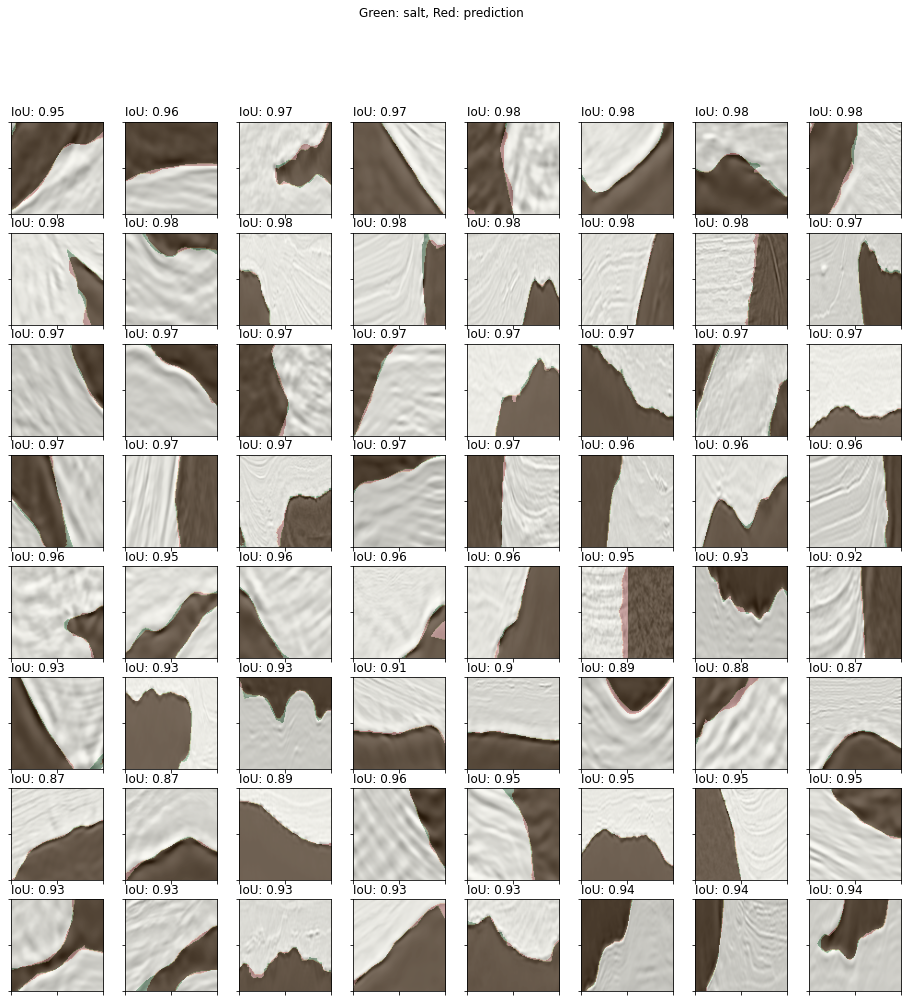

In [22]:
max_images = outputs.size(0)
grid_width = 8
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width*2, grid_height*2))
for i, _data in enumerate(zip(images, masks, preds, ious)):
    image, mask, pred, iou = _data
#     image=image.cuda()
#     mask=mask.cuda()
#     pred=pred.cuda()
#     iou=iou.cuda()
    image=image.cpu().numpy()
    mask=mask.cpu().numpy()
    pred=pred.cpu().numpy()
    ax = axs[int(i / grid_width), i % grid_width]
    
    ax.imshow(image.squeeze(), cmap = "Greys")
    ax.imshow(mask.squeeze(), alpha = 0.5, cmap = "Greens")
    ax.imshow(pred.squeeze(), alpha = 0.3, cmap = "OrRd")
    ax.set_title("IoU: " + str(round(iou, 2)), loc = 'left')
    
    ax.set_yticklabels([])
    ax.set_xticklabels([])
plt.suptitle("Green: salt, Red: prediction")
plt.show()

In [23]:
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

transforms = T.Compose([T.Grayscale(), T.ToTensor()])

In [24]:
image_path = "/kaggle/working/competition_data/test/images"
sub_df = pd.read_csv('/kaggle/working/competition_data/sample_submission.csv')
n = sub_df.shape[0]
rle_mask = []
for idx in range(n):
    ## load image
    sample_name = sub_df['id'][idx]
    image = Image.open(os.path.join(image_path, sample_name+'.png') )
    image = transforms(image)
    image=image.cuda()
    ## predict
    out = model(image.unsqueeze(0)).squeeze()
    pred = torch.where(out<0., torch.zeros_like(out), torch.ones_like(out)).cpu()
    ## write mask
    rle_mask.append(rle_encode(pred.numpy()))
    print("\rprogress {}/{}".format(idx+1, n), end = "")
    
sub_df['rle_mask'] = rle_mask

progress 18000/18000

In [25]:
sub_df.to_csv('submission.csv', index = False)